In [97]:
import numpy as np
import pandas as pd
import imageio
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
train_csv = pd.read_csv("../p_final/training.csv")
test_csv = pd.read_csv("../p_final/test.csv")
sample_csv = pd.read_csv("../p_final/SampleSubmission.csv")
ID_csv = pd.read_csv("../p_final/IdLookupTable.csv")

In [44]:
dev_size = 500
train_csv = train_csv.dropna()
labels = train_csv.loc[:, train_csv.columns != 'Image'].values
data = train_csv['Image'].str.split()
data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
data = data/255.0                                           # Rescale grayscale values to [0,1].
shuffle = np.random.permutation(np.arange(data.shape[0]))   # Shuffle the data
data, labels = data[shuffle], labels[shuffle]  # Splitting into dev and training
dev_data, dev_labels = data[:dev_size], labels[:dev_size]
train_data, train_labels  = data[dev_size:], labels[dev_size:]

In [45]:
def plot_example(data, label, predicted_label=np.nan):
    plt.imshow(data.reshape(96, 96), cmap='gray')
    plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
    if np.all(np.isfinite(predicted_label)):
        plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
    return

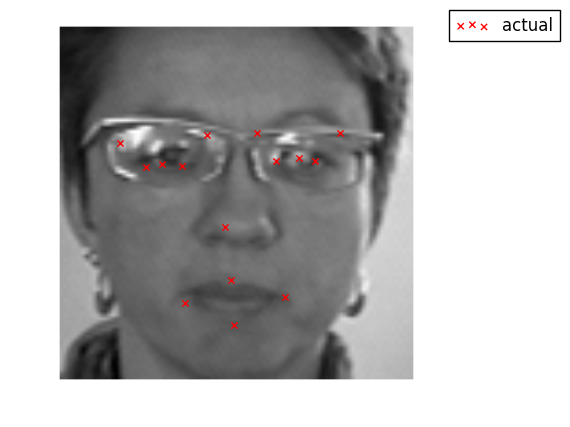

In [54]:
plot_example(train_data[20], train_labels[20])

## Face Flip Sample Generator
Since the amount of training examples is so few - we've taken a look at data augmentation options to artificially generate more training data. One option that we've found to be useful is flipping the face horizotallly and adjusting the data labels accordingly. This gives an option to double the size of our training data.

In [64]:
def face_flip(data, label):
    data = data.reshape(96,96)
    flipped = np.fliplr(data) # reverse order of each row in sample
    flipped = np.vstack(flipped) # 
    flipped = flipped.flatten()
    ## now for the labels, only need to adjust x labels
    f_label = label
    # flip indices changes any left side labels to right side and vice versa, credit daniel nouri blog
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    # write in labels to replace label array
    for a,b in flip_indices:
        f_label[a], f_label[b] = label[b], label[a]
    # adjust x labels for flip, using 47 as the origin
    for i in range(0,30, 2):
        if f_label[i] >= 47:
            f_label[i] = 47 - (f_label[i] - 47)
        else:
            f_label[i] = 47 + (47 - f_label[i])
    
            
    return flipped, f_label

We will test out the flipping face function with a training sample to make sure its working properly

In [51]:
samp_data = train_data[20].reshape(96,96)
samp_label = train_labels[20]

In [59]:
print(type(train_data[0]))

<class 'numpy.ndarray'>


### Flipped version of above

9216


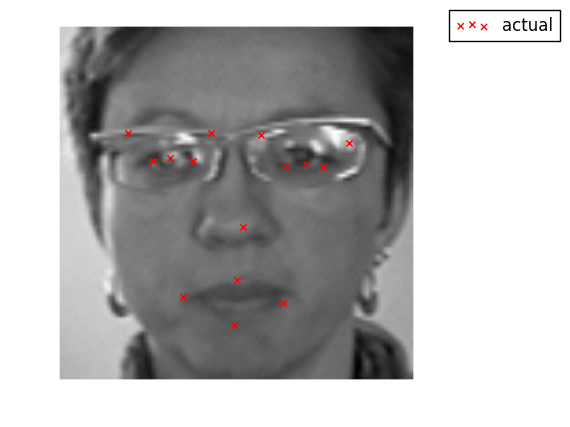

In [65]:
f_samp_data, f_samp_label = face_flip(samp_data, samp_label)
print(len(f_samp_data))
plot_example(f_samp_data, f_samp_label)

## Increase Training Data with Additional Flipped Images

In [85]:
new_train_data = train_data.copy()
new_train_labels = train_labels.copy()
print(len(new_train_data), len(new_train_labels))
# generate more training samples
for i in range(len(train_data)):
    new_data, new_label = face_flip(train_data[i], train_labels[i])
    new_train_data = np.concatenate((new_train_data, new_data.reshape(1,9216)), axis=0)
    new_train_labels = np.concatenate((new_train_labels, new_label.reshape(1,30)), axis=0)
print(len(new_train_data), len(new_train_labels))

1640 1640
3280 3280


In [87]:
sk_nn_4 = MLPRegressor(hidden_layer_sizes=(400,200), activation= 'tanh')
sk_nn_4.fit(new_train_data, new_train_labels)
#sk_nn_1.score(dev_data, dev_labels)
preds_4 = sk_nn_4.predict(dev_data)

In [88]:
def evaluate(preds, labels):
    preds, labels = np.vstack(preds), np.vstack(labels)
    return np.sqrt(np.sum((labels - preds)**2) / (30*len(preds)))

In [89]:
print(evaluate(preds_4, dev_labels))

3.3131155401


In [92]:
test_data = test_csv['Image'].str.split()
test_data = np.vstack(test_data.apply(lambda row: np.asarray([int(n) for n in row])).values)
test_data = test_data/255.0
test_preds = sk_nn_4.predict(test_data)

In [95]:
def sub_gen(predictions):
    df = pd.DataFrame(predictions, columns=train_csv.columns[:-1])
    pos = []
    for index, row in ID_csv.iterrows():
        pos.append((
            row['RowId'],
            df.iloc[row.ImageId - 1][row.FeatureName],
        ))

    sub = pd.DataFrame(pos, columns=('RowId', 'Location'))
    sub.to_csv("./sub120317_01.csv", index=False)

In [96]:
sub_gen(test_preds)

In [90]:
sk_nn_5 = MLPRegressor(hidden_layer_sizes=(400,200), activation= 'tanh')
sk_nn_5.fit(train_data, train_labels)
#sk_nn_1.score(dev_data, dev_labels)
preds_5 = sk_nn_5.predict(dev_data)

In [91]:
print(evaluate(preds_5, dev_labels))

3.25629547741


## Having some fun, labeling our own faces

In [116]:
im = imageio.imread('cag_img.jpg')
im_gray = np.dot(im[...,:3], [.3, .6, .1])
img2 = im_gray.flatten() / 255.0
print(img2.shape)

(9216,)


In [117]:
im = imageio.imread('cag_img.jpg')
im_gray = np.dot(im[...,:3], [.3, .6, .1])
img2 = im_gray.flatten() / 255.0
img2 = img2.reshape(1, 9216)
img2_label = sk_nn_5.predict(img2)

[[ 66.21886935  36.85263236  29.61566719  37.08195539  59.30884014
   37.86211138  73.36544897  37.66385398  36.5813998   37.93871551
   22.36285281  38.05760905  56.1970584   29.20707247  79.56166324
   29.67759288  39.28661885  29.40094371  15.74652421  30.51814516
   48.06559547  57.17915561  63.42596636  75.85426226  33.06284997
   76.12784494  48.15080974  72.59377851  48.22379275  82.56045136]]


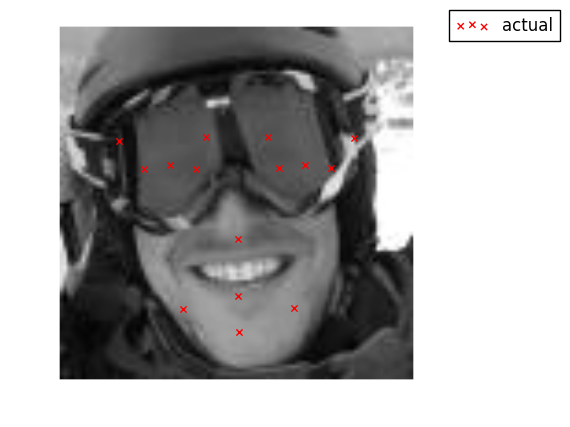

In [118]:
print(img2_label)
plot_example(img2, img2_label[0])